In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import xgboost as xgb
import bisect

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

from autogluon.tabular import TabularPredictor, TabularDataset

In [4]:
train = pd.read_csv('train_fillna.csv')
test = pd.read_csv('test_fillna.csv')
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute
0,SG,GIW5,Container,30.881018,2018-12-17 21:29:00,Z618338,30.0,24,24300,10.0,...,26.566667,2.472586,5,0.002615,3.450000,2018,12,17,21,29
1,IN,UJM2,Bulk,0.000000,2014-09-23 06:59:00,X886125,30.0,13,35900,10.0,...,30.420000,2.859073,12,0.000217,0.000000,2014,9,23,6,59
2,CN,EUC8,Container,0.000000,2015-02-03 22:00:00,T674582,50.0,12,146000,30.0,...,7.828889,3.436586,6,0.001614,0.000000,2015,2,3,22,0
3,JP,ZAG4,Container,0.000000,2020-01-17 04:02:00,Y847238,20.0,18,6910,10.0,...,6.700000,2.629350,13,0.000356,0.000000,2020,1,17,4,2
4,SG,GIW5,Container,27.037650,2020-01-26 07:51:00,A872328,50.0,10,116000,20.0,...,25.600000,2.495953,15,0.002615,253.554444,2020,1,26,7,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391905,JP,QYY1,Container,0.000000,2017-06-06 05:02:00,Y375615,20.0,27,6820,10.0,...,26.471795,2.025558,14,0.000552,0.000000,2017,6,6,5,2
391906,SG,GIW5,Bulk,5.884603,2019-10-16 00:36:00,K635567,10.0,12,3160,10.0,...,27.300000,1.253491,8,0.002615,144.061389,2019,10,16,0,36
391907,US,QGN3,Bulk,70.660241,2021-03-23 22:35:00,J284147,30.0,8,60300,20.0,...,21.100000,4.766257,18,0.000155,41.482222,2021,3,23,22,35
391908,TW,JWI3,Container,9.448179,2015-01-08 07:15:00,J644215,30.0,29,23800,10.0,...,20.960784,3.173085,15,0.000990,7.485278,2015,1,8,7,15


In [6]:
train['U_WIND'].fillna(train['U_WIND'].mean(), inplace=True)
train['V_WIND'].fillna(train['V_WIND'].mean(), inplace=True)
train['AIR_TEMPERATURE'].fillna(train['AIR_TEMPERATURE'].mean(), inplace=True)
train['BN'].fillna(train['BN'].mean(), inplace=True)

In [7]:
test['U_WIND'].fillna(train['U_WIND'].mean(), inplace=True)
test['V_WIND'].fillna(train['V_WIND'].mean(), inplace=True)
test['AIR_TEMPERATURE'].fillna(train['AIR_TEMPERATURE'].mean(), inplace=True)
test['BN'].fillna(train['BN'].mean(), inplace=True)

In [9]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute

In [10]:
# datetime 컬럼 처리
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute

In [11]:
train_dist_zero=train[train['DIST']==0]
train_dist=train[train['DIST']!=0]
test_dist_zero=test[test['DIST']==0]
test_dist=test[test['DIST']!=0]

In [12]:
train_dist['GT/Port_Size']=train_dist['GT']/train_dist['PORT_SIZE'] 
test_dist['GT/Port_Size']=test_dist ['GT']/test_dist ['PORT_SIZE']
train_dist['SIZE/Port_Size']=(train_dist['LENGTH']*train_dist['BREADTH']*train_dist['DEPTH'])/train_dist['PORT_SIZE'] 
test_dist['SIZE/Port_Size']=(test_dist['LENGTH']*test_dist['BREADTH']*test_dist['DEPTH'])/test_dist ['PORT_SIZE']

In [13]:
# 풍향 계산
import math
wind_direction_rad_train = [math.atan2(float(u), float(v)) for u, v in zip(train_dist['U_WIND'], train_dist['V_WIND'])]
wind_direction_train = [math.degrees(rad) for rad in wind_direction_rad_train]
wind_direction_rad_test = [math.atan2(float(u), float(v)) for u, v in zip(test_dist['U_WIND'], test_dist['V_WIND'])]
wind_direction_test = [math.degrees(rad) for rad in wind_direction_rad_test]
train_dist['WIND_DIRECTION']=wind_direction_train
test_dist['WIND_DIRECTION']=wind_direction_test

In [14]:
# 풍속 계산
U_WIND_array_train = train_dist['U_WIND'].values
V_WIND_array_train = train_dist['V_WIND'].values
wind_speed_array_train = np.sqrt(U_WIND_array_train**2 + V_WIND_array_train**2)
U_WIND_array_test = test_dist['U_WIND'].values
V_WIND_array_test = test_dist['V_WIND'].values
wind_speed_array_test = np.sqrt(U_WIND_array_test**2 + V_WIND_array_test**2)
train_dist['WIND_SPEED'] = wind_speed_array_train
test_dist['WIND_SPEED'] = wind_speed_array_test

In [15]:
train_dist['ARI_CO_mean']=0
test_dist['ARI_CO_mean']=0
# train_dist에 ARI_CO_mean 변수 추가
ARI_CO_mean=[]
for i in train_dist['ARI_CO'].unique():
    ARI_CO_mean.append(train_dist[train_dist['ARI_CO']==i]['CI_HOUR'].mean())
for j in range(len(train_dist['ARI_CO'].unique())):
    train_dist.loc[train_dist['ARI_CO'] == train_dist['ARI_CO'].unique()[j]
                   , 'ARI_CO_mean'] = ARI_CO_mean[j]

In [16]:
for j in range(len(train_dist['ARI_CO'].unique())):
    test_dist.loc[test_dist['ARI_CO'] == train_dist['ARI_CO'].unique()[j]
                   , 'ARI_CO_mean'] = ARI_CO_mean[j]

In [17]:
train_dist['ARI_PO_mean']=0
test_dist['ARI_PO_mean']=0

In [18]:
ARI_PO_mean=[]
for i in train_dist['ARI_PO'].unique():
    ARI_PO_mean.append(train_dist[train_dist['ARI_PO']==i]['CI_HOUR'].mean())
for j in range(len(train_dist['ARI_PO'].unique())):
    train_dist.loc[train_dist['ARI_PO'] == train_dist['ARI_PO'].unique()[j]
                   , 'ARI_PO_mean'] = ARI_PO_mean[j]

In [19]:
for j in range(len(train_dist['ARI_PO'].unique())):
    test_dist.loc[test_dist['ARI_PO'] == train_dist['ARI_PO'].unique()[j]
                   , 'ARI_PO_mean'] = ARI_PO_mean[j]

In [20]:
from datetime import date
for i in train_dist.index:
    train_dist.loc[i, 'weekday'] = date(train_dist['year'][i],
                                 train_dist['month'][i],
                                 train_dist['day'][i]).weekday()
for i in test_dist.index:
    test_dist.loc[i, 'weekday'] = date(test_dist['year'][i],
                                 test_dist['month'][i],
                                 test_dist['day'][i]).weekday()

In [21]:
# Categorical 컬럼 인코딩
train_dist=train_dist.drop(columns='ATA')
test_dist=test_dist.drop(columns='ATA')
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train_dist[feature] = le.fit_transform(train_dist[feature].astype(str))
    le_classes_set = set(le.classes_)
    test_dist[feature] = test_dist[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test_dist[feature] = le.transform(test_dist[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.28it/s]


In [22]:
X_train = train_dist.drop(columns='CI_HOUR')
y_train = train_dist['CI_HOUR'].reset_index(drop=True)

In [23]:
test_index=test_dist.index

In [24]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train)
                               , columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(test_dist),
                              columns=test_dist.columns)

In [25]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

Model Tune for XGB.


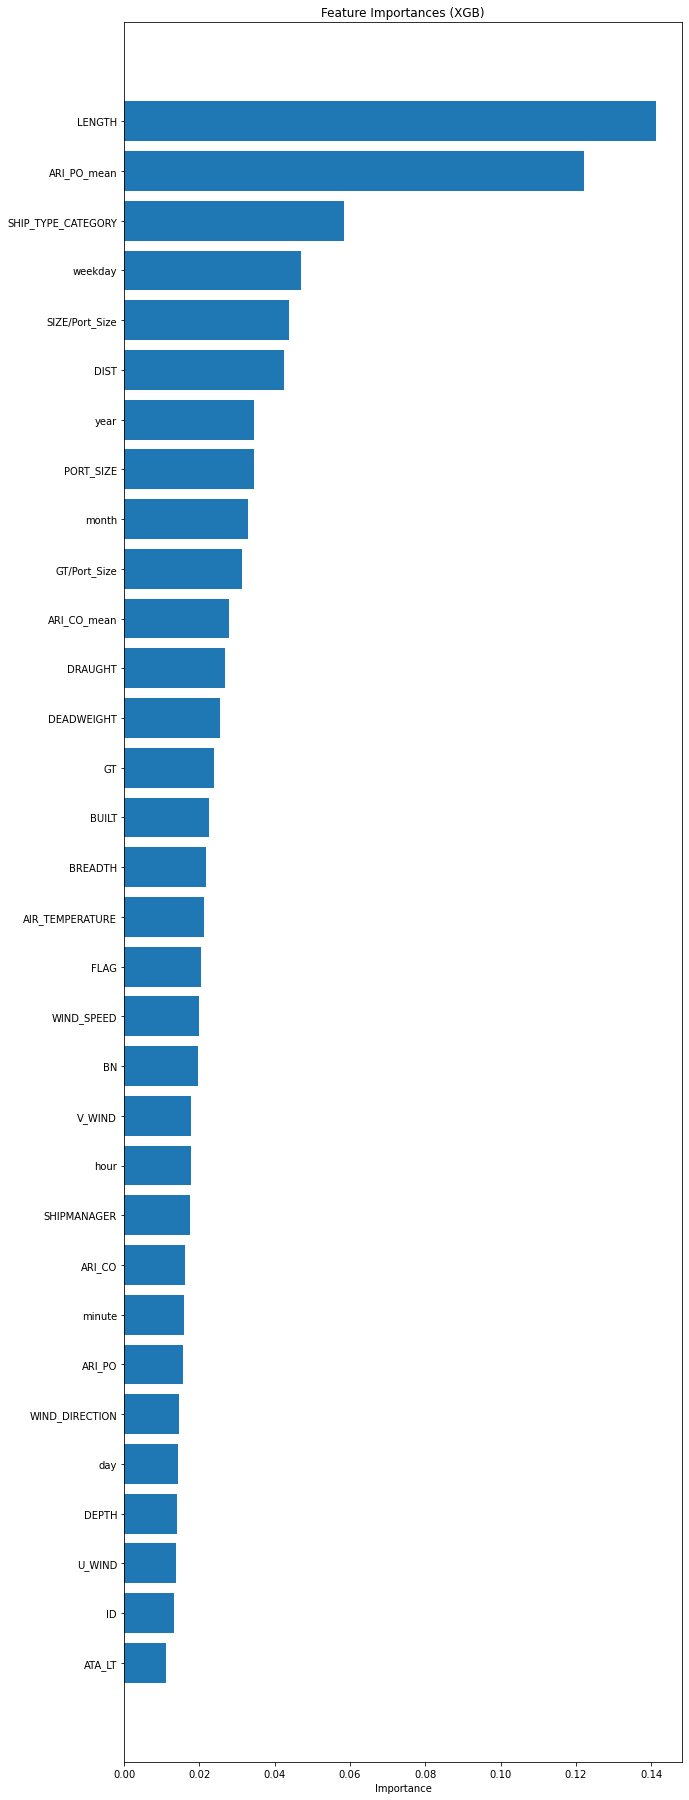

In [26]:
# Model Tune for LGBM
lgbm_model, lgbm_feature_importances1 = train_and_evaluate(xgb.XGBRegressor()
                                                          , 'XGB'
                                                          , X_train, y_train)

In [ ]:
threshold = 85 # Your Threshold
low_importance_features= X_train.columns[lgbm_feature_importances1 < threshold]
X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)
X_train_reduced['CI_HOUR']=y_train

In [ ]:
predictor = TabularPredictor(label='CI_HOUR',problem_type = 'regression',eval_metric='mae' )   
predictor.fit(train_data = X_train_reduced, presets = 'best_quality',
              auto_stack = True, fit_weighted_ensemble = True,
              num_bag_folds = 2, num_bag_sets = 3, num_stack_levels = 2,
              num_cpus = 8, verbosity = 2)

In [ ]:
pred_y = predictor.predict(X_test_reduced)

In [ ]:
pred_y

In [ ]:
pred_y.index=test_index

In [ ]:
submit = pd.read_csv('../DAT/sample_submission.csv')
submit['CI_HOUR']=0

In [ ]:
submit.loc[pred_y.index, 'CI_HOUR'] = pred_y

In [ ]:
submit

In [ ]:
submit.to_csv('./submit1.csv', index=False)